In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model


from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face
from tyssue.core.objects import get_opposite

In [2]:
datasets = load_datasets('small_hexagonal.hf5',
                         data_names=['face', 'vert', 'edge'])
datasets['edge'] = datasets['edge'][['srce', 'trgt', 'face']]
datasets['face'] = datasets['face'][['x', 'y', 'z', 'is_alive']]
datasets['vert'] = datasets['vert'][['x', 'y', 'z']]

specs = config.geometry.sheet_spec()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

boundary_cells = sheet.face_df[sheet.face_df.is_alive==0].index
for cell in boundary_cells:
    remove_face(sheet, cell)

sheet.reset_index()
sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

face_z = sheet.upcast_face(sheet.face_df['z'])

left = face_z[face_z<0].index
left_border = sheet.edge_df.loc[left][sheet.edge_df.loc[left]['opposite']==-1]

right = face_z[face_z>0].index
right_border = sheet.edge_df.loc[right][sheet.edge_df.loc[right]['opposite']==-1]



left_cell_edges = left_border.copy()
right_cell_edges = right_border.copy()

left_face = sheet.face_df.index.max()+1
right_face = sheet.face_df.index.max()+2

left_cell_edges[['srce', 'trgt']] = left_cell_edges[['trgt', 'srce']]
left_cell_edges['face'] = left_face

right_cell_edges[['srce', 'trgt']] = right_cell_edges[['trgt', 'srce']]
right_cell_edges['face'] = right_face


left_vert = sheet.vert_df.loc[left_cell_edges['srce']]
right_vert = sheet.vert_df.loc[right_cell_edges['srce']]

new_faces = pd.DataFrame(data=0,
                         index=[left_face, right_face],
                         columns=sheet.face_df.columns)

sheet.edge_df = sheet.edge_df.append(left_cell_edges)
sheet.edge_df = sheet.edge_df.append(right_cell_edges)
sheet.face_df = sheet.face_df.append(new_faces)
sheet.face_df['is_alive'] = 1


sheet.reset_topo()
sheet.reset_index()


geom.update_all(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/config/geometry/__init__.py:181: UserWarning: Deprecated, use spherical_sheet(), cylindrical_sheet() or flat_sheet() instead
  warnings.warn("Deprecated, use spherical_sheet(), "


In [5]:
draw_specs = config.draw.sheet_spec()
draw_specs['face']['visible'] = True
vp_view(sheet, **draw_specs)

(<SceneCanvas (PyQt4) at 0x7f6a0828cf60>, <ViewBox at 0x7f6a08141f60>)

In [59]:
sheet.face_df = sheet.face_df.loc[sheet.face_df.index.delete(55)]

sheet.face_df.tail()

,x,y,z,is_alive,area,num_sides,perimeter,vol
face,,,,,,,,
52,4.019221e+00,-4.019221e+00,-7.401487e-17,1,18.865118,6.0,16.239088,37.502048
53,5.251365e+00,-2.175186e+00,4.072821e+00,1,18.865118,6.0,16.239088,37.502048
54,3.617298e+00,-4.216089e+00,7.874121e+00,1,18.669681,5.0,17.078073,36.083223
56,-1.554312e-15,6.106227e-16,-1.018205e+01,1,97.553434,8.0,35.959068,182.702784
57,-1.637579e-15,4.440892e-16,1.018205e+01,1,97.553434,8.0,35.959068,182.702784


In [6]:
from tyssue.topology.sheet_topology import cell_division

In [7]:
cell_division(sheet, left_face, geom)

58

In [14]:
geom.update_all(sheet)

In [9]:
cell_division(sheet, right_face, geom)

59

In [13]:
sheet.reset_index()
sheet.reset_topo()

In [17]:
vp_view(sheet, **draw_specs)

(<SceneCanvas (PyQt4) at 0x7f69f7f236d8>, <ViewBox at 0x7f69f6c1d6a0>)

In [16]:
left_daughter = 59
right_daughter = 58
for face in [left_daughter, 
             right_daughter,
             left_face,
             right_face]:
    
    daughter = cell_division(sheet, face, geom)
    sheet.reset_index()
    sheet.reset_topo()
    geom.update_all(sheet)

In [110]:
from tyssue.core.generation import extrude
from tyssue.core.monolayer import Monolayer, MonolayerWithLamina
from tyssue.geometry.bulk_geometry import BulkGeometry, MonoLayerGeometry
from tyssue.dynamics.bulk_model import BulkModel, LaminaModel, set_model

sheet.datasets['edge'] = sheet.datasets['edge'][['srce', 'trgt', 'face', 'cell']]
sheet.datasets['vert'] = sheet.datasets['vert'][['x', 'y', 'z']]
sheet.datasets['face'] = sheet.datasets['face'][['x', 'y', 'z']]

datasets = extrude(sheet.datasets,scale=0.5)

specs = config.geometry.bulk_spec()

mono = Monolayer('ell', datasets, specs)
mono.reset_index()
mono.reset_topo()

BulkGeometry

# ## Settings for the quasi-static model
# ### Apical layer
apical_spec = {
    'edge': {
        'line_tension': 0.12,
        'prefered_length': 0.0,
        'length_eleasticity': 0.0},
    'face': {
        'contractility': 0.04,
        'prefered_area': 0.5,
        'area_elasticity': 1.0},
    'cell': {
        'prefered_vol': 1.0,
        'vol_elasticity': 1.0},
    'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0},}

# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.01},
        'face': {
            'contractility': 0.01,
            'prefered_area': 0.2} # increase the sagittal prefered area to obtain anisotropic cells
    },
    'basal': {
        'edge': {
            'line_tension': 0.12},
        'face': {
            'contractility': 0.04,
            'prefered_area': 0.5}},
    }

set_model(mono, BulkModel, apical_spec, modifiers)




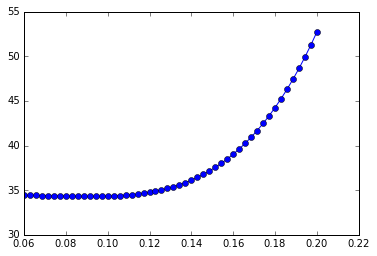

In [112]:
energies = []
deltas = np.linspace(0.06, 0.2)
for delta in deltas:
    BulkGeometry.scale(mono, delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    energies.append(BulkModel.compute_energy(mono))
    BulkGeometry.scale(mono, 1/delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    

fig, ax = plt.subplots()

ax.plot(deltas, energies, 'o-')


In [113]:
delta = deltas[np.argmin(energies)]

BulkGeometry.scale(mono, delta, mono.coords)
BulkGeometry.update_all(mono)

In [104]:
print(mono.face_df.loc[mono.apical_faces, 'area'].min(),
      mono.face_df.loc[mono.basal_faces, 'area'].min(),
      mono.face_df.loc[mono.sagittal_faces, 'area'].min())

0.0192420740649 0.157153018188 0.283430044337


In [100]:
from tyssue.solvers.sheet_vertex_solver import Solver


In [122]:
res = Solver.find_energy_min(mono, BulkGeometry, BulkModel)

In [123]:
vp_view(mono)




(<SceneCanvas (PyQt4) at 0x7f69e3c465c0>, <ViewBox at 0x7f69e3b69780>)

In [116]:
from tyssue.io.hdf5 import save_datasets

In [124]:
save_datasets('small_ellipsoid.hf5', mono)

In [118]:
mono.face_df.loc[mono.basal_faces, 'prefered_area'] *= 0.8
mono.face_df.loc[mono.sagittal_faces, 'prefered_area'] *= 0.4


In [126]:
from tyssue.io.obj import save_junction_mesh
save_junction_mesh('ellipsoid.obj', mono)

                be advised the file cannot be read back in vispy


'/home/guillaume/Notebooks/tyssue'